# Analyse solar droughts over small area

Records mean daily irradiance values (by averaging 10 min datasets) for a given subset of the total area. Solar droughts are found using a simple definition, and plotted with two methods. The first plot shows how many total solar droughts are occuring across the time series, and the second plot shows the number of droughts that each area experienced during that time.

In [1]:
from netCDF4 import Dataset
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import cartopy.crs as ccrs
import pandas as pd
import sys
sys.path.append('code/python/scripts')
import utils

In [2]:
# Hard coded variables

# Dates to analyse (inclusive)
start_date = '5-5-2022'
end_date = '15-5-2022'
# Coordinates of area to analyse
area_bounds = {
"lat_min": -38.6,
"lat_max": -37.3,
"lon_min": 143.8,
"lon_max": 145.8,
} # Melbourne area

In [3]:
# Use the given hard coded variables to get irradiance data.
# Irradiance is averaged across the day, so each day just has a single mean irradiance value
rad_df = utils.read_irradiance(
    start_date=start_date,
    end_date=end_date,
    area_bounds=area_bounds
)

File not found: /g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1s/latest/2022/05/05/IDE00326.202205050240.nc.
File not found: /g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1s/latest/2022/05/05/IDE00326.202205050830.nc.
File not found: /g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1s/latest/2022/05/06/IDE00326.202205060140.nc.
File not found: /g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1s/latest/2022/05/06/IDE00326.202205060240.nc.
File not found: /g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1s/latest/2022/05/07/IDE00326.202205070240.nc.
File not found: /g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1s/latest/2022/05/08/IDE00326.202205072040.nc.
File not found: /g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1s/latest/2022/05/08/IDE00326.202205080240.nc.
File not found: /g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1s/latest/2022/05/08/IDE00326.202205080950.nc.
File not found: 

In [4]:
# Drought definition:
# A day is considered to be in a solar drought if the daily irradiance is less than 50% of the
# mean daily irradiance across the whole period.

if 'is_drought_day' not in rad_df.columns: # so multiple columns are not created by accident
    
    # the mean daily irradiance for the start_date to end_date period.
    # Maintaining the regional resolution, so mean is calculated for each pixel individually
    total_mean = np.ma.mean(np.ma.stack(rad_df['daily_mean'].values), axis=0)
    
    # Drought day represented by boolean array: True if drought day, False if not
    is_drought_day = [
        np.ma.masked_array(
            dm < total_mean * 0.5,  # day is less than 50% of mean
            mask=np.ma.getmask(dm) | np.ma.getmask(total_mean)  # Combine masks
        )
        for dm in rad_df['daily_mean']
    ]
    # Add boolean drought day data to DF, using original date index
    rad_df = pd.concat([rad_df, pd.DataFrame({'is_drought_day': is_drought_day}, index = rad_df.index)], axis=1)

# For the first plot, sums up all boolean is_drought_day values for each day,
# to give time series of daily data that shows how many pixels meet the conditions for
# drought on each day
if 'coincident_droughts' not in rad_df.columns:
    
    # count the number of droughts occuring at the same time
    coincident_droughts = [np.sum(droughts) for droughts in is_drought_day]
    rad_df = pd.concat([rad_df, pd.DataFrame({'coincident_droughts': coincident_droughts}, index=rad_df.index)], axis=1)

# Data for second plot.
# For each pixel, sum up all the droughts it experienced across all days in the time series.
num_drought_days = np.ma.sum(np.ma.stack(is_drought_day), axis=0)

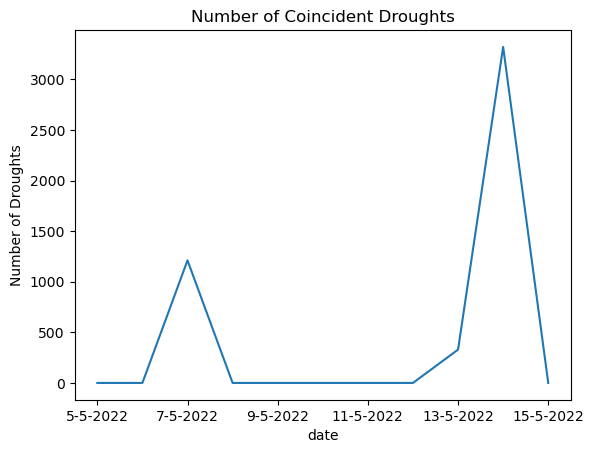

In [5]:
ax = rad_df['coincident_droughts'].plot()
plt.title('Number of Coincident Droughts')
plt.savefig(f'/home/548/cd3022/figs/melb_coincident_drought_timeline_{start_date}_{end_date}')
plt.ylabel('Number of Droughts')
plt.show()

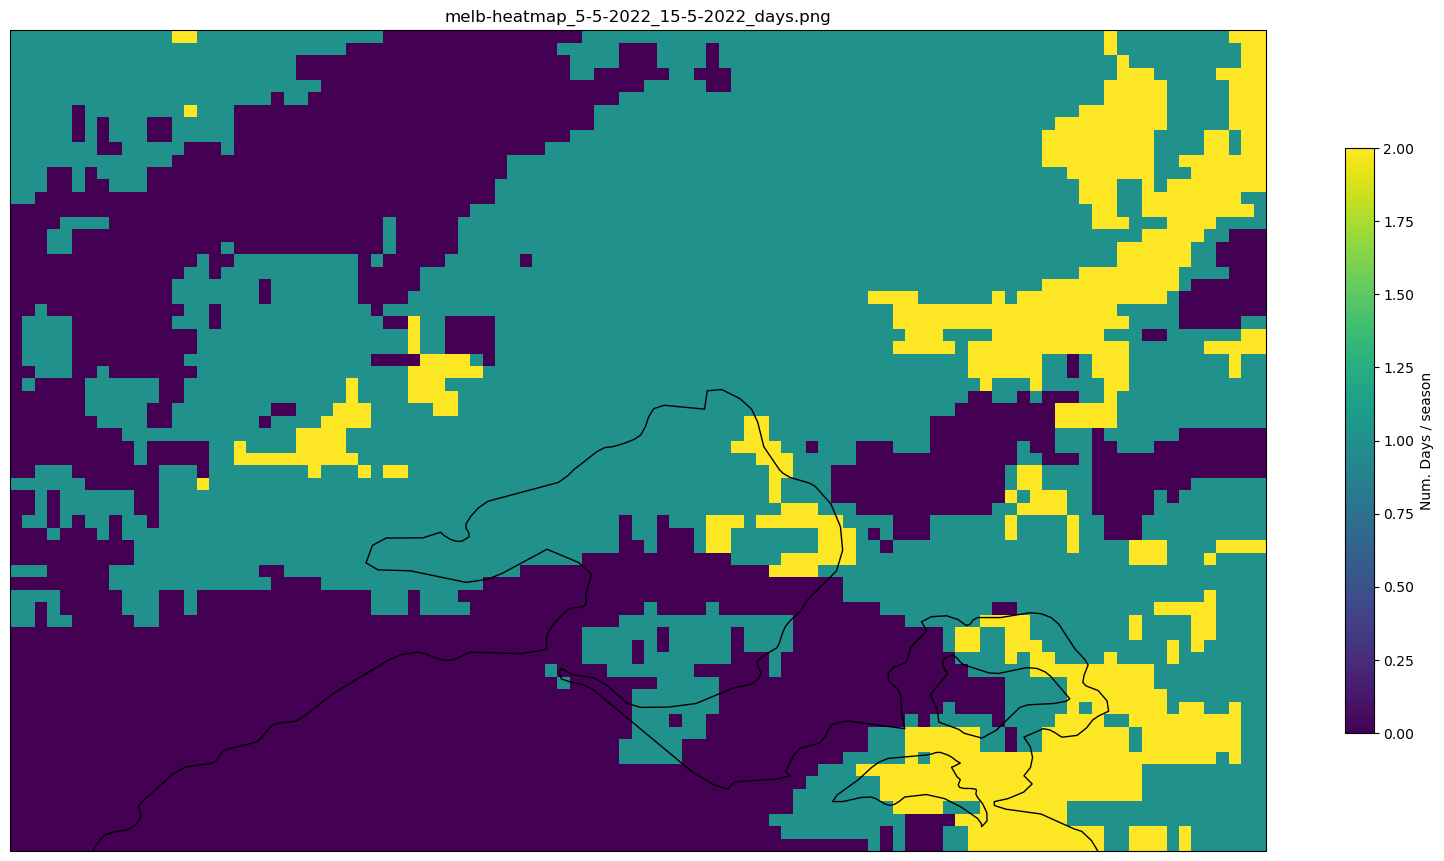

In [6]:
fig_name = f'melb-heatmap_{start_date}_{end_date}_days.png'
utils.plot_area(
    data=num_drought_days,
    area_bounds=area_bounds,
    fig_name=fig_name
)